In [1]:
import os
import re
import pandas as pd
import numpy as np

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import confusion_matrix,precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import chi2
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.base import TransformerMixin, BaseEstimator

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def print_accuracy(y_true, y_pred):
    print(confusion_matrix(y_true,y_pred))
    print("precision:", precision_score(y_true,y_pred))
    print("recall:", recall_score(y_true,y_pred))

In [5]:
def plot_coefs(df, top_features=20):
    df_sorted = df.sort_values(by="coef", ascending = False)
    top_positive_coefs = df_sorted[:top_features]
    top_negative_coefs = df_sorted[-top_features:]
    top_coefs = pd.concat([top_positive_coefs,top_negative_coefs], axis = 0).sort_values(by="coef")
    # create plot
    plt.figure(figsize=(20, 5))
    top_coefs['coef'].plot(kind="bar")
    plt.show()

In [6]:
train_test_cross_df = pd.read_csv(r"../data/train.txt",sep="|")
eval_df = pd.read_csv(r"../data/eval.txt",sep="|")
print(train_test_cross_df.shape, eval_df.shape)
train_test_cross_df[:3]

(4940, 3) (770, 3)


,ID,REMARKS,BAD
0,3736142,"""R/O's observed above subject with two other s...",1
1,3761761,"""LOITERING IN CITGO GAS STATION, FIELD INTERVI...",0
2,3746471,"""SUBJECT, A KNOWN LA RAZA GANG MEMBER, WAS LOI...",1


In [7]:
# Remove NAs
train_test_cross_df2 = train_test_cross_df[~pd.isnull(train_test_cross_df['REMARKS'])]
eval_df2 = eval_df[~pd.isnull(eval_df['REMARKS'])]
train_test_cross_df2.set_index("ID",inplace=True)
eval_df2.set_index("ID",inplace=True)
print(train_test_cross_df2.shape, eval_df2.shape)

(4877, 2) (759, 2)


In [8]:
print(train_test_cross_df2["BAD"].value_counts())
print(eval_df2["BAD"].value_counts())

0    2772
1    2105
Name: BAD, dtype: int64
0    385
1    374
Name: BAD, dtype: int64


#### Split into train, test, cross_validation

In [9]:
train_test_X, cross_X, train_test_y, cross_y = train_test_split(train_test_cross_df2,train_test_cross_df2['BAD'], test_size = 0.2)
print(train_test_X.shape, cross_X.shape)

(3901, 2) (976, 2)


In [10]:
train_X, test_X, train_y, test_y = train_test_split(train_test_X, train_test_y, test_size=0.25)
print(train_X.shape, test_X.shape, cross_X.shape)

(2925, 2) (976, 2) (976, 2)


In [15]:
class RemarksExtractor(TransformerMixin,BaseEstimator):
    # Need to inherit from BaseEstimator class which has method get_params that allows for GridSearch Optimization

    def __init__(self, factor, replace_num=False):
        self.factor = factor
        self.replace_num = replace_num
    
    def transform(self, X, y=None, **fit_params):
        if self.replace_num:
            processed = X[self.factor].apply(lambda x: re.sub("[0-9]+","numberph",x))
        else:
            processed = X[self.factor]
        return processed
        
    def fit(self, X, y=None, **fit_params):
        return self

In [16]:
pipeline = Pipeline([
    ("preprocessing", RemarksExtractor("REMARKS", replace_num=True)),
    ("vectorizer", TfidfVectorizer(token_pattern='(?u)\\b[a-zA-Z]+\\b', min_df=2, 
                                   ngram_range=(1,2), stop_words=['the','a','an'], use_idf=True)),
    ("feature_selector", SelectKBest(score_func=chi2, k=1000)),
    ("model",SVC(kernel="linear"))
#     ("model", MultinomialNB())
])

In [26]:
pipeline.fit(train_X, train_y)
pred_y = pipeline.predict(test_X)
print_accuracy(test_y, pred_y)

[[489  45]
 [ 91 351]]
precision: 0.886363636364
recall: 0.794117647059


In [27]:
pred_y = pipeline.predict(cross_X)
print_accuracy(cross_y, pred_y)

[[536  51]
 [ 94 295]]
precision: 0.852601156069
recall: 0.758354755784


In [28]:
params = {
    # Select preprocessing method
    "preprocessing__replace_num": (False, True),
    "vectorizer__use_idf": (False, True),
    "vectorizer__stop_words": (None,['the','a','an']),
    "vectorizer__ngram_range":((1,1),(2,2),(3,3),(4,4),(1,2),(1,3),(1,4)),
    
    # Select model
    "feature_selector__k":(200, 500, 1000),
    "model__C":(0.03, 0.1, 0.3, 1)
}
grid_search = GridSearchCV(pipeline, params, cv=3, scoring='f1', verbose=1)

In [29]:
%%time
grid_search.fit(train_test_X, train_test_y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  1.2min finished


Wall time: 1min 15s


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('preprocessing', RemarksExtractor(factor='REMARKS', replace_num=True)), ('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=2...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'feature_selector__k': (200, 500, 1000), 'model__C': (0.03, 0.1, 0.3, 1)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=1)

In [37]:
# Optimize preprocessing parameters
print(grid_search.best_score_)
print(grid_search.best_params_)

0.872442020948
{'preprocessing__replace_num': True, 'vectorizer__ngram_range': (1, 2), 'vectorizer__stop_words': ['the', 'a', 'an'], 'vectorizer__use_idf': True}


In [47]:
# Optimize model selection parameters
print(grid_search.best_score_)
print(grid_search.best_params_)

0.824739623863
{'feature_selector__k': 1000, 'model__C': 1}


In [18]:
class DenseTransformer(TransformerMixin):  # This is to tranform tfidf sparse matrix to dense matrix to apply normalization

    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit(self, X, y=None, **fit_params):
        return self

In [30]:
pipeline_opt_feat = Pipeline([
    ("preprocessing", RemarksExtractor("REMARKS", replace_num=True)),
    ("vectorizer", TfidfVectorizer(token_pattern='(?u)\\b[a-zA-Z]+\\b', min_df=2, 
                                   ngram_range=(1,2), stop_words=['the','a','an'], use_idf=True)),
    ("densetranformer",DenseTransformer()),
    
    ("feature_selector", SelectKBest(score_func=chi2, k=1000)),
    ("normalizer", preprocessing.MinMaxScaler(feature_range=[0,1])),
    ("model",LogisticRegression())
])

In [31]:
pipeline_opt_feat.fit(train_test_X, train_test_y)
pred_y = pipeline_opt_feat.predict(cross_X)
print_accuracy(cross_y, pred_y)

[[507  51]
 [ 66 352]]
precision: 0.873449131514
recall: 0.842105263158


In [32]:
pipeline_opt_feat.named_steps['model'].coef_.shape

(1, 1000)

In [33]:
# Get selected features and count
feat_selected_ind = pipeline_opt_feat.named_steps['feature_selector'].get_support()

In [34]:
feat_all = pipeline_opt_feat.named_steps['vectorizer'].get_feature_names()
feat_selected = [w for w in feat_all if feat_selected_ind[feat_all.index(w)]]
len(feat_selected)

1000

In [35]:
coef_df = pd.DataFrame(pipeline_opt_feat.named_steps['model'].coef_.T,
                       index = feat_selected, columns = ['coef'])
coef_df[:2]

,coef
abandoned property,1.074235
about,-0.603666


In [36]:
coef_df.to_excel(r"..\output\Oct 25\features_logit.xlsx")

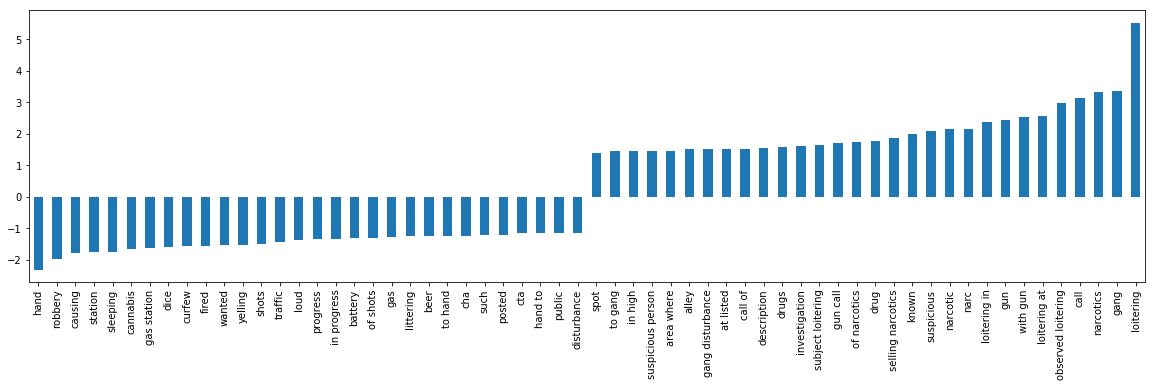

In [64]:
plot_coefs(coef_df,30)

#### Eval on evaluation set - see how much the model agrees with keyword serach labeling

In [65]:
eval_df2[:3]

,REMARKS,BAD
ID,,
3995608,"""""""NAME CHECK CLEAR""""""",1
7415322,"""""""LISTED SUBJECT WAS OBSERVED LOITERING WITH ...",1
4696416,"""""""loitering at an area known for gang and nar...",1


In [33]:
y_pred_eval = pipeline_opt_feat.predict(eval_df2)
y_pred_proba_eval = pipeline_opt_feat.predict_proba(eval_df2)
print_accuracy(eval_df2['BAD'],y_pred_eval)

[[331  54]
 [ 96 278]]
precision: 0.83734939759
recall: 0.743315508021


In [366]:
eval_df2['y_pred'] = y_pred_eval
eval_df2['proba'] = y_pred_proba_eval[:,1]
eval_df2[:3]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,REMARKS,BAD,y_pred,proba
ID,,,,
3995608,"""""""NAME CHECK CLEAR""""""",1,1,0.666293
7415322,"""""""LISTED SUBJECT WAS OBSERVED LOITERING WITH ...",1,1,0.976333
4696416,"""""""loitering at an area known for gang and nar...",1,1,0.991851


In [67]:
eval_df2.to_excel(r"../output/Oct 27/just_text_result.xlsx")
coef_df.to_excel(r"../output/Oct 27/just_text_features.xlsx")

#### Next step: add in features of date & length